In [0]:
!pip install pyforest

In [0]:
!pip install pycaret

In [ ]:
# Import required packages
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import random
import os
import itertools
import statsmodels.api as sm

import torch
import torch.nn as nn

from sklearn.preprocessing import MinMaxScaler
import pyforest
from sklearn.ensemble import RandomForestRegressor, ExtraTreesRegressor,AdaBoostRegressor
from sklearn.model_selection import cross_val_score

from pycaret.regression import *

import seaborn as sns
import warnings
warnings.filterwarnings("ignore")
plt.style.use('fivethirtyeight')

1. EDA has been performed in different notebook. Insights from that lag features has more importance than any
rolling features.
2. Data has too much voltaility so we need to do modelling more carefull. Check the leaderboard that confirms it.
3. I had cleaned this notebook to understand quickly. Many methods were tried like SARIMA, ARIMA, LSTM, Dilated CNN's but this simple approach gave 4th rank in the final private leaderboard

In [0]:
def create_lag_rolling_feat(train):
    train['lag_1'] = train['GrocerySales'].shift(1)
    train['lag_2'] = train['GrocerySales'].shift(2)
    train['lag_3'] = train['GrocerySales'].shift(3)
    train['lag_4'] = train['GrocerySales'].shift(4)
    train['lag_5'] = train['GrocerySales'].shift(5)
    train['lag_6'] = train['GrocerySales'].shift(6)
    train['lag_7'] = train['GrocerySales'].shift(7)
    train['lag_10'] = train['GrocerySales'].shift(10)
    train['lag_14'] = train['GrocerySales'].shift(14)
    train['lag_21'] = train['GrocerySales'].shift(21)
    train['lag_28'] = train['GrocerySales'].shift(28)
    
    train['roll_2_mean'] = train['GrocerySales'].rolling(2).mean().shift(1)
    train['roll_3_mean'] = train['GrocerySales'].rolling(3).mean().shift(1)
    train['roll_4_mean'] = train['GrocerySales'].rolling(4).mean().shift(1)
    train['roll_5_mean'] = train['GrocerySales'].rolling(5).mean().shift(1)
    train['roll_6_mean'] = train['GrocerySales'].rolling(6).mean().shift(1)
    train['roll_7_mean'] = train['GrocerySales'].rolling(7).mean().shift(1)
    train['roll_10_mean'] = train['GrocerySales'].rolling(10).mean().shift(1)
    train['roll_14_mean'] = train['GrocerySales'].rolling(14).mean().shift(1)
    train['roll_21_mean'] = train['GrocerySales'].rolling(21).mean().shift(1)
    train['roll_28_mean'] = train['GrocerySales'].rolling(28).mean().shift(1)
    

    train['roll_2_std'] = train['GrocerySales'].rolling(2).std().shift(1)
    train['roll_3_std'] = train['GrocerySales'].rolling(3).std().shift(1)
    train['roll_4_std'] = train['GrocerySales'].rolling(4).std().shift(1)
    train['roll_5_std'] = train['GrocerySales'].rolling(5).std().shift(1)
    train['roll_6_std'] = train['GrocerySales'].rolling(6).std().shift(1)
    train['roll_7_std'] = train['GrocerySales'].rolling(7).std().shift(1)
    train['roll_10_std'] = train['GrocerySales'].rolling(10).std().shift(1)
    train['roll_14_std'] = train['GrocerySales'].rolling(14).std().shift(1)
    train['roll_21_std'] = train['GrocerySales'].rolling(21).std().shift(1)
    train['roll_28_std'] = train['GrocerySales'].rolling(28).std().shift(1)

In [93]:
train = pd.read_csv('/content/drive/My Drive/Prophet_train.csv')
train.columns = ['GrocerySales','DS']
create_lag_rolling_feat(train)
train = train.dropna()
train.drop(['DS'],axis=1,inplace=True)
train = train.sample(frac=1)
train.head()

,GrocerySales,lag_1,lag_2,lag_3,lag_4,lag_5,lag_6,lag_7,lag_10,lag_14,lag_21,lag_28,roll_2_mean,roll_3_mean,roll_4_mean,roll_5_mean,roll_6_mean,roll_7_mean,roll_10_mean,roll_14_mean,roll_21_mean,roll_28_mean,roll_2_std,roll_3_std,roll_4_std,roll_5_std,roll_6_std,roll_7_std,roll_10_std,roll_14_std,roll_21_std,roll_28_std
217,8358.79,8180.43,8315.46,8156.05,8206.11,8162.21,8471.18,8706.007433,7511.84,7876.87,7679.54,7863.66,8247.945,8217.313333,8214.5125,8204.052,8248.573333,8313.921062,8084.992743,7993.611960,7859.517497,7879.999908,95.480629,85.867178,70.333682,65.247455,123.687829,206.497406,406.888488,375.631168,369.431105,327.855581
356,8895.35,8836.93,8705.17,8707.12,8677.98,8710.77,8767.52,8820.260000,8956.74,8768.45,8723.60,8614.90,8771.050,8749.740000,8731.8000,8727.594,8734.248333,8746.535714,8760.258000,8743.012143,8719.231905,8701.023929,93.168389,75.515049,71.337621,62.491954,58.222645,62.303733,88.448881,105.269054,115.734788,116.808414
654,8663.19,8862.09,8814.25,8813.44,8766.79,8948.38,8648.71,8795.410000,8935.09,8653.05,8673.06,9014.11,8838.170,8829.926667,8814.1425,8840.990,8808.943333,8807.010000,8830.381000,8805.277143,8798.730952,8868.725000,33.827988,27.857208,38.908984,68.843105,99.766886,91.217820,86.077302,105.254803,102.530368,169.929801
478,9043.52,9166.56,9056.33,9092.92,8804.78,9054.36,8802.49,8814.070000,8860.99,8808.61,8815.85,8833.18,9111.445,9105.270000,9030.1475,9034.990,8996.240000,8970.215714,8974.049000,8938.810000,8943.015238,8936.471786,77.944380,56.143166,157.082558,136.467749,154.622548,157.048679,142.007099,137.224666,131.344157,150.289635
457,8815.85,8831.82,9118.83,9122.25,9143.65,8638.21,8729.95,8833.180000,8973.66,8481.31,8771.77,8696.14,8975.325,9024.300000,9054.1375,8970.952,8930.785000,8916.841429,8860.823000,8815.065714,8730.532857,8697.940714,202.946717,166.701340,148.618068,226.196010,224.971187,208.656795,220.279539,218.440002,236.618559,220.607166


# Pycaret Model

In [94]:
exp_reg102 = setup(data = train, target = 'GrocerySales', train_size =0.8)

 
Setup Succesfully Completed!


,Description,Value
0,session_id,2562
1,Transform Target,False
2,Transform Target Method,None
3,Original Data,"(664, 32)"
4,Missing Values,False
5,Numeric Features,31
6,Categorical Features,0
7,Ordinal Features,False
8,High Cardinality Features,False
9,High Cardinality Method,None


In [95]:
compare_models()

,Model,MAE,MSE,RMSE,R2,RMSLE,MAPE
0,Lasso Least Angle Regression,153.956300,44599.388300,207.998900,0.757500,0.025000,0.018200
1,Bayesian Ridge,153.459500,44942.200300,208.092400,0.756300,0.025000,0.018100
2,Orthogonal Matching Pursuit,154.301000,45694.994100,210.233800,0.752300,0.025300,0.018200
3,Linear Regression,158.502100,46209.289900,211.071900,0.748400,0.025400,0.018800
4,Huber Regressor,152.524500,46566.788000,210.327500,0.747500,0.025300,0.018000
5,Lasso Regression,158.105600,47213.752200,213.154800,0.743700,0.025700,0.018700
6,Ridge Regression,158.135300,47230.212600,213.192200,0.743600,0.025700,0.018700
7,Elastic Net,158.115300,47219.754800,213.168400,0.743600,0.025700,0.018700
8,Random Forest,155.756100,47885.555900,214.818200,0.741000,0.025900,0.018500
9,Extra Trees Regressor,157.358100,48889.471900,217.008300,0.734500,0.026200,0.018600


# Stacking with meta-modelling

In [0]:
lgbm = create_model('lightgbm', fold = 10)
rf = create_model('rf', fold = 10)
et = create_model('et', fold = 10)
cat = create_model('catboost', fold = 10)
knn_model = create_model('knn', fold = 10)
bayesian = create_model('br',fold = 10)
xgboost = create_model('xgboost',fold=10)
ada = create_model('ada',fold=10)
stack_1 = stack_models([rf,cat,lgbm,knn_model,bayesian,ada], meta_model = et)
final_stack_1 = finalize_model(stack_1) Gave hghest score

stack_2 = stack_models([rf,cat,lgbm,knn_model,bayesian], meta_model = et)
final_stack_2 = finalize_model(stack_2)

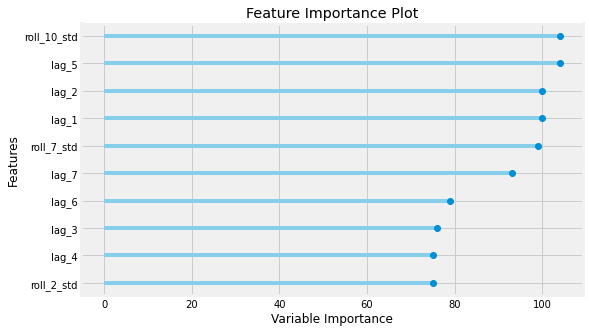

In [97]:
# feature importance to make sure mean rolling feature is not useful(mean features has been removed in the final model)
plot_model(lgbm, plot= 'feature')

In [102]:
train.head()

,GrocerySales,lag_1,lag_2,lag_3,lag_4,lag_5,lag_6,lag_7,lag_10,lag_14,lag_21,lag_28,roll_2_mean,roll_3_mean,roll_4_mean,roll_5_mean,roll_6_mean,roll_7_mean,roll_10_mean,roll_14_mean,roll_21_mean,roll_28_mean,roll_2_std,roll_3_std,roll_4_std,roll_5_std,roll_6_std,roll_7_std,roll_10_std,roll_14_std,roll_21_std,roll_28_std
217,8358.79,8180.43,8315.46,8156.05,8206.11,8162.21,8471.18,8706.007433,7511.84,7876.87,7679.54,7863.66,8247.945,8217.313333,8214.5125,8204.052,8248.573333,8313.921062,8084.992743,7993.611960,7859.517497,7879.999908,95.480629,85.867178,70.333682,65.247455,123.687829,206.497406,406.888488,375.631168,369.431105,327.855581
356,8895.35,8836.93,8705.17,8707.12,8677.98,8710.77,8767.52,8820.260000,8956.74,8768.45,8723.60,8614.90,8771.050,8749.740000,8731.8000,8727.594,8734.248333,8746.535714,8760.258000,8743.012143,8719.231905,8701.023929,93.168389,75.515049,71.337621,62.491954,58.222645,62.303733,88.448881,105.269054,115.734788,116.808414
654,8663.19,8862.09,8814.25,8813.44,8766.79,8948.38,8648.71,8795.410000,8935.09,8653.05,8673.06,9014.11,8838.170,8829.926667,8814.1425,8840.990,8808.943333,8807.010000,8830.381000,8805.277143,8798.730952,8868.725000,33.827988,27.857208,38.908984,68.843105,99.766886,91.217820,86.077302,105.254803,102.530368,169.929801
478,9043.52,9166.56,9056.33,9092.92,8804.78,9054.36,8802.49,8814.070000,8860.99,8808.61,8815.85,8833.18,9111.445,9105.270000,9030.1475,9034.990,8996.240000,8970.215714,8974.049000,8938.810000,8943.015238,8936.471786,77.944380,56.143166,157.082558,136.467749,154.622548,157.048679,142.007099,137.224666,131.344157,150.289635
457,8815.85,8831.82,9118.83,9122.25,9143.65,8638.21,8729.95,8833.180000,8973.66,8481.31,8771.77,8696.14,8975.325,9024.300000,9054.1375,8970.952,8930.785000,8916.841429,8860.823000,8815.065714,8730.532857,8697.940714,202.946717,166.701340,148.618068,226.196010,224.971187,208.656795,220.279539,218.440002,236.618559,220.607166


# Forecasting Stage

In [103]:
again_train =  pd.read_csv('/content/drive/My Drive/Prophet_train.csv')
again_train.columns = ['GrocerySales','DS']
again_train.drop(['DS'],axis=1,inplace=True)
again_train.head()

,GrocerySales
0,8418.59
1,8447.47
2,8336.49
3,8579.17
4,8524.31


In [104]:
again_train.shape

(692, 1)

In [ ]:
test_inputs = again_train.values[-28:]
test_inputs = list(itertools.chain(*test_inputs))
submission_lab = []
fut_pred = 90
for i in range(fut_pred):
    row = [test_inputs[-1],test_inputs[-2],test_inputs[-3],test_inputs[-4],
         test_inputs[-5],test_inputs[-6],test_inputs[-7],
         test_inputs[-10],test_inputs[-14],test_inputs[-21],test_inputs[-28],
         np.mean(test_inputs[-2:]),np.mean(test_inputs[-3:]),np.mean(test_inputs[-4:]),
         np.mean(test_inputs[-5:]),np.mean(test_inputs[-6:]),np.mean(test_inputs[-7:]),
         np.mean(test_inputs[-10:]),np.mean(test_inputs[-14:]),
         np.mean(test_inputs[-21:]),np.mean(test_inputs[-28:]),
         np.std(test_inputs[-2:]),np.std(test_inputs[-3:]),np.std(test_inputs[-4:]),
         np.std(test_inputs[-5:]),np.std(test_inputs[-6:]),np.std(test_inputs[-7:]),
         np.std(test_inputs[-10:]),np.std(test_inputs[-14:]),
         np.std(test_inputs[-21:]),np.std(test_inputs[-28:])]
    test_data = pd.DataFrame(columns = train.drop('GrocerySales',axis=1).columns)
    test_data.loc[0] = row
    prediction = predict_model(et,data=test_data)['Label'].values[0]
    submission_lab += [prediction]
    test_inputs += [prediction]
plt.plot(range(692,692+90),submission_lab)

In [0]:
sub12 = pd.DataFrame(columns = ['GrocerySales'])
sub12['GrocerySales'] = submission_lab
sub12.to_excel('Submission_12.xlsx',index=False)

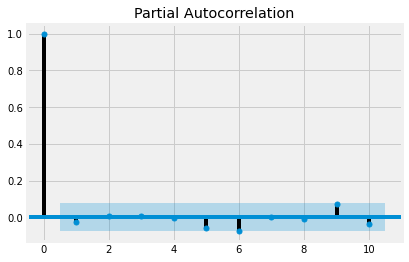

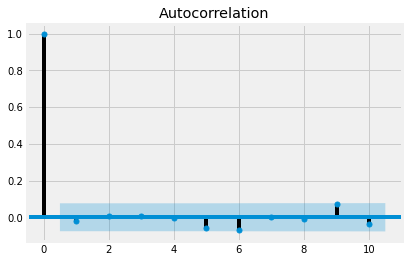

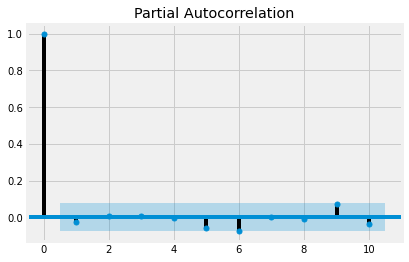

In [91]:
# This has been done to what lag features to add
from statsmodels.graphics.tsaplots import plot_acf,plot_pacf
plot_acf(train['GrocerySales'], lags=10)
plot_pacf(train['GrocerySales'], lags=10)